In [2]:
import re
import sys
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import tensorflow as tf

sys.path.append("../../ndsvae")
import ndsvae as ndsv

sys.path.append("..")
import util
import plotutils as pu


%matplotlib inline

In [3]:
conn = "linw"
preproc = "dicer"
modelname = "AB"
config = "ns_3_mreg_3_msub_0_nf_32"
run = util.select_run_fc(f"hcp100_{conn}_{preproc}", modelname, config, [0,1], "hcp")

In [4]:
hist = pd.read_csv(f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}/fit/hist.csv")

In [5]:
hist

,epoch,loss,loss_test,betax,betap,"Ap[0,0]","Ap[0,1]","Ap[0,2]",bp[0],olv,logtau,slv[0],slv[1],slv[2]
0,0,9479.798828,2826.516846,1.0,0.000,-0.105270,-0.132627,-0.189511,-0.089528,0.051939,2.219216,-1.949153,-1.947782,-1.950580
1,1,2425.018555,2133.509766,1.0,0.002,-0.012514,-0.128134,-0.152389,-0.145396,0.010655,2.140219,-1.946735,-1.937583,-1.949675
2,2,1982.405151,1880.696777,1.0,0.004,0.019749,-0.140452,-0.143863,-0.161262,-0.009742,2.065150,-1.945583,-1.934411,-1.947928
3,3,1838.161011,1809.865723,1.0,0.006,0.013189,-0.155304,-0.147851,-0.158082,-0.011299,1.993682,-1.942814,-1.933200,-1.945135
4,4,1792.973145,1780.002319,1.0,0.008,-0.001763,-0.173533,-0.154501,-0.148599,-0.012294,1.925600,-1.940407,-1.932221,-1.943012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,996,1426.225952,1446.895752,1.0,1.000,0.000184,-2.000631,0.006587,-0.030320,-5.630528,0.336556,-3.902037,-2.445437,-3.270049
997,997,1426.355347,1450.716187,1.0,1.000,-0.000496,-2.001177,0.005578,-0.031587,-5.638291,0.338494,-3.903016,-2.448584,-3.269567
998,998,1427.225952,1449.492554,1.0,1.000,-0.000036,-1.999745,0.006435,-0.030776,-5.620926,0.336343,-3.903813,-2.448270,-3.268477
999,999,1425.658691,1447.524536,1.0,1.000,0.000848,-2.000445,0.006671,-0.030223,-5.638519,0.336531,-3.902616,-2.448998,-3.268465


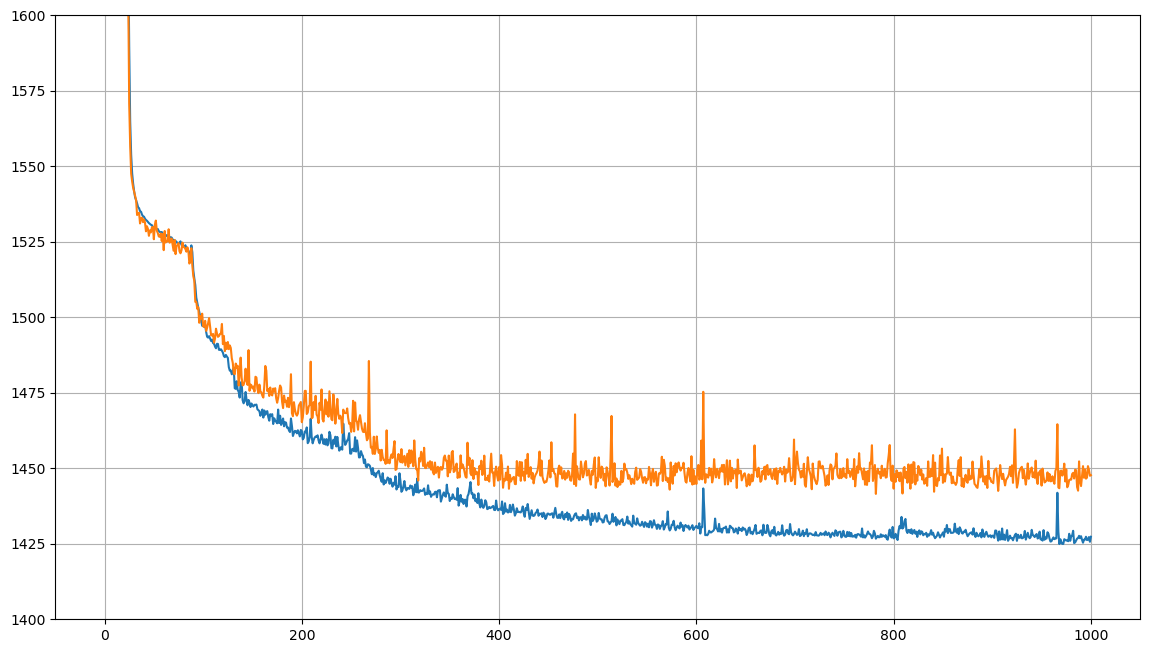

In [11]:
plt.figure(figsize=(14,8), dpi=100)

plt.plot(hist.epoch, hist.loss)
plt.plot(hist.epoch, hist.loss_test)
plt.ylim(1400, 1600)

#  plt.axvline(epoch, ls='--', color='0.5')
plt.grid()

## ELBO for train and test samples

In [14]:
ds = ndsv.Dataset.from_file(f"../run/hcp/hcp100_{conn}_{preproc}/dataset.npz")
direc = f"../run/hcp/hcp100_{conn}_{preproc}/model{modelname}/{config}/run{run:02d}"
train_mask = np.load(f"{direc}/fit/train_mask.npy")

model = util.get_model(modelname, config, ds)
model.load_weights(os.path.join(direc, "fit/model"))

batch_size = ds.nreg
dataset = ndsv.training._prep_training_dataset(ds, batch_size, model.training_mode, model.upsample_factor,
                                               mask=np.ones((ds.nsub, ds.nreg), dtype=bool), shuffle=False)

In [20]:
nsamples = 8
elbos = np.zeros((ds.nsub, ds.nreg, nsamples))
for i, batch in enumerate(dataset):
    print(i, end=' ', flush=True)
    
    model.loss(batch, nsamples=nsamples, betax=1.0, betap=1.0)
    elbos[i,:,:] = model.elbo.numpy()
    
elbo = np.mean(elbos, axis=2)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [21]:
rows = []
for i in range(ds.nsub):
    for j in range(ds.nreg):
        rows.append(dict(sub=i, reg=j, train=train_mask[i,j], elbo=elbo[i,j]))
df = pd.DataFrame(rows)

## Figure

In [22]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

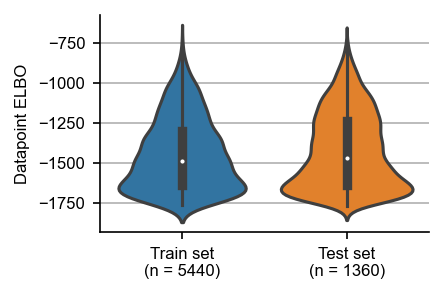

In [37]:
plt.figure(figsize=(3,2), dpi=150)
sns.violinplot(data=df, y='elbo', x='train', zorder=10)
plt.grid(axis='y')
plt.ylabel("Datapoint ELBO")
plt.xlabel("")
plt.xticks([0,1], [f"Train set\n(n = {np.sum(df.train)})", f"Test set\n(n = {np.sum(~df.train)})"])

plt.gca().set_axisbelow(True)
pu.bottomleft_spines(plt.gca())
plt.tight_layout()

plt.savefig("img/Fig_HCP-overfitting.pdf")

In [38]:
np.mean(df.elbo[df.train]), np.mean(df.elbo[~df.train])

(-1424.1693344663172, -1445.8009405584896)